In [73]:
BLACKHOLE = False


import os
import sys
from pathlib import Path


if BLACKHOLE:
    workspace_path = os.path.expandvars('$BLACKHOLE')
    sys.path.append(workspace_path+'/DeepLearning/02456_news_project/src')
    DATAPATH = Path(workspace_path+"/DeepLearning/ebnerd_data").expanduser()
else:
    DATAPATH = Path("~/ebnerd_data").expanduser()

DATASET = "ebnerd_demo"
#DATASET = "ebnerd_small"

Packages:
- torch (PyTorch)
- transformers (Huggingface)

In [74]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.5.1+cu124
cuda


TODO HERFRA OG NED

In [ ]:
from utils.data_handler import NewsDataset
import from_ebrec._constants as cs

SEED = 42
HISTORY_SIZE = 50

COLS = [
    cs.DEFAULT_USER_COL,
    cs.DEFAULT_IMPRESSION_ID_COL,
    cs.DEFAULT_IMPRESSION_TIMESTAMP_COL,
    cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    cs.DEFAULT_CLICKED_ARTICLES_COL,
    cs.DEFAULT_INVIEW_ARTICLES_COL,

    cs.DEFAULT_ARTICLE_ID_COL,
    cs.DEFAULT_AGE_COL,
    cs.DEFAULT_READ_TIME_COL
]

FRACTION = 0.01
#FRACTION = 0.1
#FRACTION = 1

# test
dataset = NewsDataset()

dataset.setup_df(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)


In [76]:
import transformers as huggingface
from from_ebrec._nlp import get_transformers_word_embeddings
from from_ebrec._polars import concat_str_columns
from from_ebrec._articles import convert_text2encoding_with_transformers
from from_ebrec._articles import create_article_id_to_value_mapping

dataset.setup_articles_data(dataset_path = DATAPATH.joinpath(DATASET))

df_articles = dataset.df_articles

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = [cs.DEFAULT_SUBTITLE_COL, cs.DEFAULT_TITLE_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = huggingface.AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = huggingface.AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH)
article_mapping = create_article_id_to_value_mapping(df=df_articles, value_col=token_col_title)



In [77]:
from dataloader import NRMSDataLoader

BATCH_SIZE = 64

train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=BATCH_SIZE,
)
val_dataloader = NRMSDataLoader(
    behaviors= dataset.df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=BATCH_SIZE,
)


In [ ]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms

hparams = hparams_nrms()

# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 20
hparams.head_dim = 20
hparams.attention_hidden_dim = 200
hparams.linear_hidden_dim = 400

hparams.use_positional_encoding = True
hparams.use_learned_positions = True

# MODEL OPTIMIZER:
hparams.optimizer = "adam"
hparams.loss = "cross_entropy_loss"
hparams.dropout = 0.2
hparams.learning_rate = 1e-4

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding, debug=False)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(250002, 768)
    (dropout): Dropout(p=0.2, inplace=False)
    (positional_encoder): NewsEncoderWithPosition(
      (position_embeddings): Embedding(30, 768)
    )
    (self_attention): SelfAttention()
    (dense_layers): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): ReLU()
      (2): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=400, out_features=400, bias=True)
      (5): ReLU()
      (6): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=400, out_features=400, bias=True)
      (9): ReLU()
      (10): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
      (11): Dropout(p=0.2, inplace=False)
    )
    (att_layer): AttLayer2()
  )
  (user_encoder): UserEncoder(
    (title_encoder): NewsEncoder(
      (embedding): Embedding

In [79]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss() 
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [80]:
from tqdm import tqdm  # for progress bars
# Train the model 

EPOCHS = 10

# Move model to GPU if available
model.to(device)

# Training loop
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{EPOCHS}"):
        # Unpacking of batch
        (inputs, labels) = batch
        his_input_title, pred_input_title = inputs

        # Move data to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)

        labels = labels.to(device)

        # Forward pass
        outputs = model(pred_input_title, his_input_title)  
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{EPOCHS}"):
            (inputs, labels) = batch
            his_input_title, pred_input_title = inputs

            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            labels = labels.to(device)

            outputs = model(pred_input_title, his_input_title)
            loss = criterion(outputs, labels)

            #print("Output")
            #print(outputs.tolist())
            #print("Labels")
            #print(labels.tolist())
            #print("")   
            
            val_loss += loss.item()

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Validation Epoch 1/10: 100%|██████████| 6/6 [00:00<00:00, 17.76it/s]


Epoch 1/10: Train Loss = 1.6569, Val Loss = 1.5950


Validation Epoch 2/10: 100%|██████████| 6/6 [00:00<00:00, 16.04it/s]


Epoch 2/10: Train Loss = 1.6500, Val Loss = 1.5950


Validation Epoch 3/10: 100%|██████████| 6/6 [00:00<00:00, 16.04it/s]


Epoch 3/10: Train Loss = 1.6503, Val Loss = 1.6088


Validation Epoch 4/10: 100%|██████████| 6/6 [00:00<00:00, 18.75it/s]


Epoch 4/10: Train Loss = 1.6509, Val Loss = 1.6270


Validation Epoch 5/10: 100%|██████████| 6/6 [00:00<00:00, 18.84it/s]


Epoch 5/10: Train Loss = 1.6494, Val Loss = 1.6259


Validation Epoch 6/10: 100%|██████████| 6/6 [00:00<00:00, 19.11it/s]


Epoch 6/10: Train Loss = 1.6448, Val Loss = 1.6201


Validation Epoch 7/10: 100%|██████████| 6/6 [00:00<00:00, 17.72it/s]


Epoch 7/10: Train Loss = 1.6403, Val Loss = 1.6247


Validation Epoch 8/10: 100%|██████████| 6/6 [00:00<00:00, 18.62it/s]


Epoch 8/10: Train Loss = 1.6384, Val Loss = 1.6175


Validation Epoch 9/10: 100%|██████████| 6/6 [00:00<00:00, 17.54it/s]


Epoch 9/10: Train Loss = 1.6344, Val Loss = 1.6268


Validation Epoch 10/10: 100%|██████████| 6/6 [00:00<00:00, 18.52it/s]


Epoch 10/10: Train Loss = 1.6377, Val Loss = 1.6177


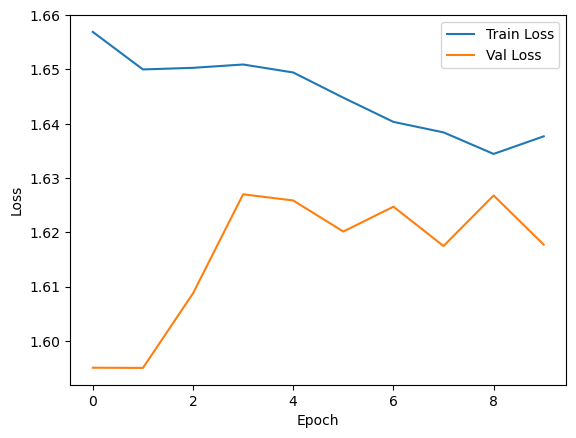

In [82]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [83]:
# Evaluate the model
BATCH_SIZE_TEST = 1 # Currently onoy supports batch size 1

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False, # Is true in EBREC, but then it does not work
    batch_size=BATCH_SIZE_TEST,
)

# go from [[a], [b], [c]] to [a, b, c]
def convert_to_list(l):
    return [(item) for sublist in l for item in sublist]
model.eval()

pred_test = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Test"):
        (inputs, labels) = batch
        his_input_title, pred_input_title = inputs


        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title)

        #print("Output")
        #print(outputs.tolist())
        #print("Labels")
        #print(labels.tolist())
        bob = convert_to_list(outputs.tolist())
        #print(bob)
        #print(convert_to_int_list(labels.tolist()))
        #print("")


        pred_test.append(bob)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels= dataset.df_test["labels"].to_list(),
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()

AUC: 100%|███████████████████████████████| 2535/2535 [00:00<00:00, 40237.51it/s]


<MetricEvaluator class>: 
 {
    "auc": 0.5308416556288937,
    "mrr": 0.3187014500085601,
    "ndcg@5": 0.35978880576975486,
    "ndcg@10": 0.439471882636638
}

In [84]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.040 vs 0.000
0.019 vs 0.000
0.002 vs 0.000
0.002 vs 0.000
0.008 vs 0.000
0.164 vs 0.000
0.031 vs 0.000
0.002 vs 0.000
0.005 vs 0.000
0.314 vs 0.000
0.011 vs 0.000
0.030 vs 1.000
0.004 vs 0.000
0.025 vs 0.000
0.040 vs 0.000
0.105 vs 0.000
0.196 vs 0.000
0.002 vs 0.000

Article 1
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.001 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.001 vs 1.000
0.997 vs 0.000
0.000 vs 0.000
0.000 vs 0.000

Article 2
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
1.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 1.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000
0.000 vs 0.000

Article 3
0.240 vs 1.000
0.068 vs 0.000
0.593 vs 0.000
0.006 vs 0.000
0.008 vs 0.000
0.085 vs 0.000

Article 4
0.011 vs 0.000
0.043 vs 0.000
0.004 vs 0.000
0.931 vs 0.000
0.004 vs 0.000
0.005 vs 1.000
0.002 vs 0.000

Article 5
0.000 vs 0.000
1.000